<center>
    
## Aprendizaje No Supervisado - DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Embeddings y Agrupamiento con el FIFA 2019 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Visualizacion con embeddings:tSNE](#3.-Visualizacion-con-embeddings:tSNE)
4. [Componentes Principales](#4.-Componentes-Principales)
5. [Clustering](#5.-Clustering)


## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [28]:
import numpy as np
import pandas as pd
import random
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [35]:
from sklearn import (manifold, preprocessing, decomposition)
from sklearn.cluster import KMeans,MeanShift
import time

In [3]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [16]:
df = df = pd.read_csv("./players_21.csv")
df

sofifa_id                                         player_url  \
0         158023  https://sofifa.com/player/158023/lionel-messi/...   
1          20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2         200389  https://sofifa.com/player/200389/jan-oblak/210002   
3         188545  https://sofifa.com/player/188545/robert-lewand...   
4         190871  https://sofifa.com/player/190871/neymar-da-sil...   
...          ...                                                ...   
18939     256679  https://sofifa.com/player/256679/kevin-angulo/...   
18940     257710  https://sofifa.com/player/257710/mengxuan-zhan...   
18941     250989  https://sofifa.com/player/250989/zhenghao-wang...   
18942     257697  https://sofifa.com/player/257697/zitong-chen/2...   
18943     257936   https://sofifa.com/player/257936/yue-song/210002   

              short_name                            long_name  age  \
0               L. Messi       Lionel Andrés Messi Cuccittini   33   
1      Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35   
2               J. Oblak                            Jan Oblak   27   
3         R. Lewandowski                   Robert Lewandowski   31   
4              Neymar Jr        Neymar da Silva Santos Júnior   28   
...                  ...                                  ...  ...   
18939          K. Angulo                         Kevin Angulo   24   
18940     Zhang Mengxuan                       Mengxuan Zhang   21   
18941      Wang Zhenghao                                  王政豪   20   
18942        Chen Zitong                          Zitong Chen   23   
18943           Song Yue                             Yue Song   28   

              dob  height_cm  weight_kg nationality  \
0      1987-06-24        170         72   Argentina   
1      1985-02-05        187         83    Portugal   
2      1993-01-07        188         87    Slovenia   
3      1988-08-21        184         80      Poland   
4      1992-02-05        175         68      Brazil   
...           ...        ...        ...         ...   
18939  1996-04-13        176         73    Colombia   
18940  1999-04-26        177         70    China PR   
18941  2000-06-28        185         74    China PR   
18942  1997-02-20        186         80    China PR   
18943  1991-11-20        185         79    China PR   

                                 club_name              league_name  \
0                             FC Barcelona   Spain Primera Division   
1                                 Juventus          Italian Serie A   
2                          Atlético Madrid   Spain Primera Division   
3                        FC Bayern München     German 1. Bundesliga   
4                      Paris Saint-Germain           French Ligue 1   
...                                    ...                      ...   
18939                      América de Cali  Colombian Liga Postobón   
18940  Chongqing Dangdai Lifan FC SWM Team     Chinese Super League   
18941                      Tianjin TEDA FC     Chinese Super League   
18942        Shijiazhuang Ever Bright F.C.     Chinese Super League   
18943                      Tianjin TEDA FC     Chinese Super League   

       league_rank  overall  potential  value_eur  wage_eur player_positions  \
0              1.0       93         93   67500000    560000       RW, ST, CF   
1              1.0       92         92   46000000    220000           ST, LW   
2              1.0       91         93   75000000    125000               GK   
3              1.0       91         91   80000000    240000               ST   
4              1.0       91         91   90000000    270000          LW, CAM   
...            ...      ...        ...        ...       ...              ...   
18939          1.0       47         52      40000       500               CM   
18940          1.0       47         52      35000      1000               CB   
18941          1.0       47         51      35000      1000               CB   

Hacemos lo que hicimos en la notebook 1 con las posiciones de los jugadores, para poder visualzar después por posición

In [17]:
# A diferencia del dataset usado en clase del fifa 2019, en este cada jugador puede tener asignada mas de una posicion
# Por eso para realizar el conteo de las posiciones tomamos la primera de las posiciones asignada a cada jugador
df['first_position'] = df['player_positions'].apply(lambda x: x.split(', ')[0])

Conteos por posiciones

In [19]:
pd.DataFrame(df.first_position.value_counts().sort_index())

first_position
CAM            1148
CB             3252
CDM            1514
CF              115
CM             2241
GK             2084
LB             1402
LM             1069
LW              420
LWB             100
RB             1363
RM             1065
RW              438
RWB              88
ST             2645

# 3.-Visualizacion-con-embeddings:tSNE

In [20]:
n_sne=2000 # elegimos las primeras 2000 filas para agilizar los cálculos
df_sne=df.loc[:n_sne]

# Seleccionamos las columnas con las habilidades de interes
skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                  'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
                  'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
                  'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving',
                  'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

X=df_sne[skills_ratings]
print('dimensión del espacio de los datos: ', len(skills_ratings))

dimensión del espacio de los datos:  33


In [21]:
X.head(5)

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  85                   95                          70   
1                  84                   95                          90   
2                  13                   11                          15   
3                  71                   94                          85   
4                  85                   87                          62   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0                       91                 88               96           93   
1                       82                 86               88           81   
2                       43                 13               12           13   
3                       84                 89               85           79   
4                       87                 87               95           88   

   skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0                 94                  91                  96   
1                 76                  77                  92   
2                 14                  40                  30   
3                 85                  70                  88   
4                 89                  81                  95   

   movement_acceleration  movement_sprint_speed  movement_agility  \
0                     91                     80                91   
1                     87                     91                87   
2                     43                     60                67   
3                     77                     78                77   
4                     94                     89                96   

   movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                  94                95                86             68   
1                  95                71                94             95   
2                  88                49                59             78   
3                  93                82                89             84   
4                  91                83                80             62   

   power_stamina  power_strength  power_long_shots  mentality_aggression  \
0             72              69                94                    44   
1             84              78                93                    63   
2             41              78                12                    34   
3             76              86                85                    81   
4             81              50                84                    51   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                       40                     93                95   
1                       29                     95                82   
2                       19                     11                65   
3                       49                     94                79   
4                       36                     87                90   

   mentality_penalties  mentality_composure  defending_standing_tackle  \
0                   75                   96                         35   
1                   84                   95                         32   
2                   11                   68                         12   
3                   88                   88                         42   
4                   92                   93                         30   

   defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  \
0                        24                   6                    11   
1                        24                   7                    11   
2                        18                  87                    92   
3                        19                  15                     6   
4                        29                   9                     9   

   goalkeeping_kicking  goalkeeping_positioning  goalkeepi

Transformamos el espacio de dim 34 en un espacio de dimensión 2 (n_components=2)

In [98]:
time_start = time.time()

# seteamos una semilla porque con tsne, diferentes inicializaciones pueden dar diferentes resultados.
np.random.seed(2021)
tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2001 samples in 0.001s...
[t-SNE] Computed neighbors for 2001 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2001
[t-SNE] Computed conditional probabilities for sample 2000 / 2001
[t-SNE] Computed conditional probabilities for sample 2001 / 2001
[t-SNE] Mean sigma: 14.038059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.802856
[t-SNE] KL divergence after 1000 iterations: 1.309171
t-SNE done! Time elapsed: 14.4660005569458 seconds


In [99]:
X_tsne[1990:2000] #diez jugadores

array([[ 22.458906 ,   9.014929 ],
       [ 17.509312 ,  32.97646  ],
       [-27.406021 ,  30.372519 ],
       [-17.70338  , -16.938639 ],
       [-20.764061 ,  -9.859554 ],
       [ 40.81009  ,  21.263428 ],
       [ 24.267    ,   8.272772 ],
       [ 45.7734   ,  16.15159  ],
       [-19.03796  ,  -7.8757176],
       [-44.258575 ,  31.830282 ]], dtype=float32)

**GRAFICAMOS: Scatter plot** 


In [100]:
#Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE
#agregamos los nombres de los ckack ("Overall" más de 85)  y vemos una tercera variable recorriendo los puntos sobre el gráfico

data=[]
bool_crack=df_sne["overall"] > 85 #diferenciamos a los mejores jugadores

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'first_position'],
                           marker=dict(size=5)
                           )

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Los más mejores',
                      text=df_sne.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[graf1,crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=700)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Queremos ver si los jugadores se agrupan en el espacio de las habilidades (transformado/reducido por tsne) según la posición. Como en la notebook 1, cuando miramos la posición de cada jugador en el gráfico de la proyección obtenida con tsne, los arqueros se diferencian claramente del resto de los jugadores. Para analizar el clúster grande del resto de los jugadores hacemos también como en la notebook 1 y agrupamos las posiciones en 3 grupos: defensores, mediocampo y delanteros, además de los arqueros.

In [101]:
dict_pos = {'CB':'Defensor', 'RB':'Defensor', 'LB':'Defensor', 'RWB':'Defensor', 'LWB':'Defensor',
        'CM':'Mediocampo', 'CDM':'Mediocampo', 'CAM':'Mediocampo', 'RM':'Mediocampo', 'LM':'Mediocampo', 
        'ST':'Delantero', 'CF':'Delantero', 'RF':'Delantero', 'LF':'Delantero', 'RW':'Delantero', 'LW': 'Delantero',
        'GK':'Arquero'}
df_sne['type_position'] = df_sne['first_position'].replace(dict_pos)
df_sne["type_position"].value_counts()

Mediocampo    786
Defensor      603
Delantero     400
Arquero       212
Name: type_position, dtype: int64

**GRAFICAMOS** 


Marcamos ahora en el gráfico cada tipo de posición con un color distinto

In [102]:
bool_striker= df_sne["type_position"] == 'Delantero'
bool_midfielder= df_sne["type_position"] == 'Mediocampo'
bool_defender= df_sne["type_position"] == 'Defensor'
bool_gk= df_sne["type_position"] == 'Arquero'

bool_crack=df_sne["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

striker =go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],name='Striker',
                      text=df_sne.loc[bool_striker,'short_name'],
                      opacity=0.9,marker=dict(color=palette[2],size=5),mode='markers')

midfielder =go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],name='Midfielder',
                      text=df_sne.loc[bool_midfielder,'short_name'],
                      opacity=0.6,marker=dict(color=palette[1],size=5),mode='markers')

defender =go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],name='Defender',
                      text=df_sne.loc[bool_defender,'short_name'],
                      opacity=0.7,marker=dict(color=palette[3],size=5),mode='markers')

gk =go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],name='GK',
                      text=df_sne.loc[bool_gk,'short_name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Top player',
                      text=df_sne.loc[bool_crack,'short_name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1150,height=750)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Vemos que si bien hay un poco de mezcla, sobre todo los celestes (delanteros) y los rojos (mediocampistas) en la parte superior del plano, se ve que hay un poco de diferencia entre los diferentes tipos de posiciones. En particular, los delanteros y los defensores (naranja) están bien separados.

Sin embargo, el tipo de posición no explica tan claramente los clusters encontrados. Puede ser porque hay jugadores ambivalentes que unen los espacios entre defensa y mediocampo, y mediocampo y ataque. También puede ser que otras variables que no estamos graficando expliquen mejor los grupos.

Por último, aplicamos k-medias y Mean-shift al espacio tsne, es decir, usando "X_tsne[:,0]" y "X_tsne[:,0]" para ver cuantos clusters encuentra.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

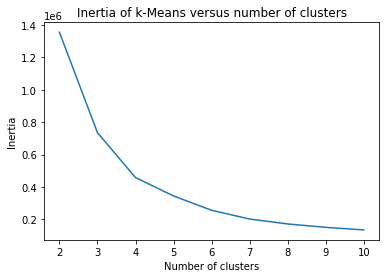

In [103]:
# kMeans

# Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 10 clusters
scores = [KMeans(n_clusters=i).fit(X_tsne).inertia_ for i in range(2,11)]

plt.plot(np.arange(2, 11), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [104]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(X_tsne) #utiliza todas las habilidades: 33 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  458273.59375


Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida en el espacio de tsne

In [105]:
# columna con los valores 0, 1, 2, 3 que indica a que cluster pertenece cada jugador según kMeans
df_sne["cluster"] = clusters

In [106]:
bool_c0= df_sne["cluster"] == 0
bool_c1= df_sne["cluster"] == 1
bool_c2= df_sne["cluster"] == 2
bool_c3= df_sne["cluster"] == 3

bool_crack=df_sne["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

striker =go.Scatter(x=X_tsne[bool_c0,0], y=X_tsne[bool_c0,1],name='Cluster 0',
                      text=df_sne.loc[bool_striker,'short_name'],
                      opacity=0.9,marker=dict(color=palette[1],size=5),mode='markers')

midfielder =go.Scatter(x=X_tsne[bool_c1,0], y=X_tsne[bool_c1,1],name='Cluster 1',
                      text=df_sne.loc[bool_midfielder,'short_name'],
                      opacity=0.6,marker=dict(color=palette[3],size=5),mode='markers')

defender =go.Scatter(x=X_tsne[bool_c2,0], y=X_tsne[bool_c2,1],name='Cluster 2',
                      text=df_sne.loc[bool_defender,'short_name'],
                      opacity=0.7,marker=dict(color=palette[2],size=5),mode='markers')

gk =go.Scatter(x=X_tsne[bool_c3,0], y=X_tsne[bool_c3,1],name='Cluster 3',
                      text=df_sne.loc[bool_gk,'short_name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Top player',
                      text=df_sne.loc[bool_crack,'short_name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1150,height=750)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [115]:
# Mean-shift

ms = MeanShift(bandwidth=18, bin_seeding=True)

ms.fit(X_tsne)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 4


In [117]:
# columna con los valores 0, 1, 2, 3 que indica a que cluster pertenece cada jugador según kMeans
df_sne["cluster2"] = clusters2

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     200389  https://sofifa.com/player/200389/jan-oblak/210002   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   33  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35  1985-02-05   
2           J. Oblak                            Jan Oblak   27  1993-01-07   

   height_cm  weight_kg nationality        club_name             league_name  \
0        170         72   Argentina     FC Barcelona  Spain Primera Division   
1        187         83    Portugal         Juventus         Italian Serie A   
2        188         87    Slovenia  Atlético Madrid  Spain Primera Division   

   league_rank  overall  potential  value_eur  wage_eur player_positions  \
0          1.0       93         93   67500000    560000       RW, ST, CF   
1          1.0       92         92   46000000    220000           ST, LW   
2          1.0       91         93   75000000    125000               GK   

  preferred_foot  international_reputation  weak_foot  skill_moves  \
0           Left                         5          4            4   
1          Right                         5          4            5   
2          Right                         3          3            1   

       work_rate             body_type real_face  release_clause_eur  \
0     Medium/Low                 Messi       Yes         138400000.0   
1       High/Low            C. Ronaldo       Yes          75900000.0   
2  Medium/Medium  PLAYER_BODY_TYPE_259       Yes         159400000.0   

                                         player_tags team_position  \
0  #Dribbler, #Distance Shooter, #FK Specialist, ...           CAM   
1  #Aerial Threat, #Dribbler, #Distance Shooter, ...            LS   
2                                                NaN            GK   

   team_jersey_number loaned_from      joined  contract_valid_until  \
0                10.0         NaN  2004-07-01                2021.0   
1                 7.0         NaN  2018-07-10                2022.0   
2                13.0         NaN  2014-07-16                2023.0   

  nation_position  nation_jersey_number  pace  shooting  passing  dribbling  \
0              RW                  10.0  85.0      92.0     91.0       95.0   
1              LS                   7.0  89.0      93.0     81.0       89.0   
2              GK                   1.0   NaN       NaN      NaN        NaN   

   defending  physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  \
0       38.0    65.0        NaN          NaN         NaN          NaN   
1       35.0    77.0        NaN          NaN         NaN          NaN   
2        NaN     NaN       87.0         92.0        78.0         90.0   

   gk_speed  gk_positioning  \
0       NaN             NaN   
1       NaN             NaN   
2      52.0            90.0   

                                       player_traits  attacking_crossing  \
0  Finesse Shot, Long Shot Taker (AI), Speed Drib...                  85   
1  Power Free-Kick, Flair, Long Shot Taker (AI), ...                  84   
2                   GK Long Throw, Comes For Crosses                  13   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
0                   95                          70                       91   
1                   95                          90                       82   
2                   11                          15                       43   

   ...  movement_balance  power_shot_power  power_jumping  power_stamina  \
0  ...                95                86             68             72   
1  ...                71                94             95             84   
2  ...                49                59             78             41  

In [119]:
bool_c0= df_sne["cluster"] == 0
bool_c1= df_sne["cluster"] == 1
bool_c2= df_sne["cluster"] == 2
bool_c3= df_sne["cluster"] == 3

bool_crack=df_sne["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

striker =go.Scatter(x=X_tsne[bool_c0,0], y=X_tsne[bool_c0,1],name='Cluster 0',
                      text=df_sne.loc[bool_striker,'short_name'],
                      opacity=0.9,marker=dict(color=palette[1],size=5),mode='markers')

midfielder =go.Scatter(x=X_tsne[bool_c1,0], y=X_tsne[bool_c1,1],name='Cluster 1',
                      text=df_sne.loc[bool_midfielder,'short_name'],
                      opacity=0.6,marker=dict(color=palette[3],size=5),mode='markers')

defender =go.Scatter(x=X_tsne[bool_c2,0], y=X_tsne[bool_c2,1],name='Cluster 2',
                      text=df_sne.loc[bool_defender,'short_name'],
                      opacity=0.7,marker=dict(color=palette[2],size=5),mode='markers')

gk =go.Scatter(x=X_tsne[bool_c3,0], y=X_tsne[bool_c3,1],name='Cluster 3',
                      text=df_sne.loc[bool_gk,'short_name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Top player',
                      text=df_sne.loc[bool_crack,'short_name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1150,height=750)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Podemos observar que ambos algoritmos encuentran basicamente los mismos clusters y que hay una cierta correspondencia con los tipos de posiciones, pero no es exacta ya que con kMeans y Mean-shift no hay mezcla entre los cluster como ocurria cuando coloreabamos según el tipo de posición

# 4.-Componentes-Principales 

**Variables de desempeño (skills_ratings)**

**Retiramos arqueros y jugadores con bajo ranking**


In [124]:
df_acp=df.loc[:]
df_acp=df_acp[(df_acp["first_position"]!='GK')&(df_acp['overall']>70)]

skills_ratings =['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                  'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
                  'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
                  'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                  'defending_standing_tackle', 'defending_sliding_tackle']

#otros skills_ratings, sacamos las habilidades de los arqueros

Restringimos los datos a las variables numéricas que consideramos

In [125]:
X=df_acp[skills_ratings] # Datos para proyectar
print('los datos tienen dimesión n =', len(skills_ratings))

los datos tienen dimesión n = 28


**Se computan las componentes principales**

La descomposición PCA del sklearn centra los datos pero no los estandariza, por eso **estandarizamos primero**

In [126]:
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled=std_scale.transform(X) # numpyarray Estandarizado (le resta la media y divide por el desvío) por columna

In [127]:
print(X_scaled[0:2])
X.head(2)

[[ 1.6217076   2.24159455  0.53092218  3.06795361  2.07369041  2.50369911
   2.10726822  2.45293533  2.62902957  3.32756469  1.62606858  0.76914599
   1.68189827  3.98039768  2.06646982  1.50780732 -0.08605603 -0.12607284
  -0.06897361  2.18910258 -1.86104269 -0.9344097   2.00667882  2.52042167
   1.25860083  3.67247759 -1.18857302 -1.52353973]
 [ 1.54486929  2.24159455  2.18188642  1.60517404  1.94563897  1.72894244
   1.28854559  1.32147458  1.1605561   2.75404353  1.30837166  1.66672702
   1.35305659  4.16371525  0.18881899  2.23265601  2.14477949  1.07571814
   0.7044603   2.12137057 -0.40195955 -1.49490521  2.14679501  1.41589401
   1.94471173  3.52498387 -1.33741906 -1.52353973]]


attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  85                   95                          70   
1                  84                   95                          90   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0                       91                 88               96           93   
1                       82                 86               88           81   

   skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0                 94                  91                  96   
1                 76                  77                  92   

   movement_acceleration  movement_sprint_speed  movement_agility  \
0                     91                     80                91   
1                     87                     91                87   

   movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                  94                95                86             68   
1                  95                71                94             95   

   power_stamina  power_strength  power_long_shots  mentality_aggression  \
0             72              69                94                    44   
1             84              78                93                    63   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                       40                     93                95   
1                       29                     95                82   

   mentality_penalties  mentality_composure  defending_standing_tackle  \
0                   75                   96                         35   
1                   84                   95                         32   

   defending_sliding_tackle  
0                        24  
1                        24

**DESCOMPOSICIÓN PCA**

En la descomposición podemos elegir n_components para quedarnos con una cantidad chica de componentes la idea es que sean "bastante" menos que la dimensión de lo datos pero que describan un buen porcentaje de la dispersión de los datos. Para elegir n también utilizamos el "método del codo" en el gráfico de la proporción de varianza por componente acumulada

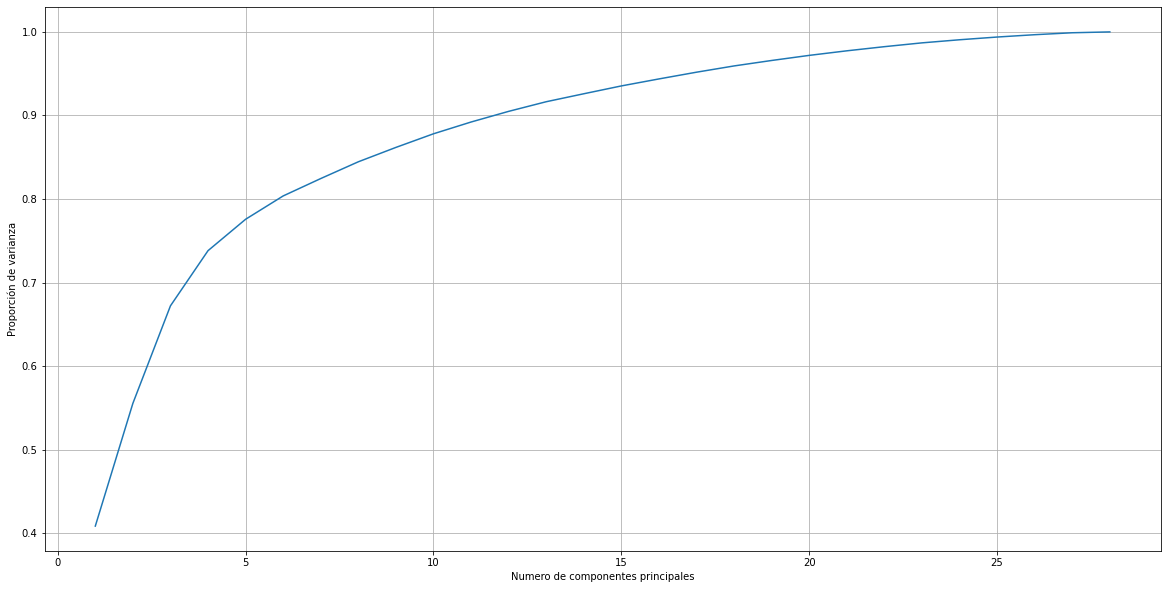

In [136]:
pca = decomposition.PCA(n_components=len(skills_ratings))
pca.fit(X_scaled)
cum_explained = np.cumsum(pca.explained_variance_ratio_)
cum_explained
plt.figure(figsize=(20,10))
plt.plot(range(1,len(skills_ratings)+1),cum_explained)
plt.xlabel("Numero de componentes principales")
plt.ylabel("Proporción de varianza")
plt.grid()
plt.show()

Convendría elegir entre 4 y 6, elegimos 4

In [137]:
pca=decomposition.PCA(n_components=4)  

pca.fit(X_scaled) 
# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)


proporción de varianza por componente:  [0.40856763 0.14689614 0.11670241 0.06603604]
proporción de varianza por componente acumulada:  [0.40856763 0.55546376 0.67216618 0.73820222]
tamaño de los datos:  (4068, 4)


In [139]:
print (X_projected[0:5])#5 primeros jugadores, n_components

[[-9.60604605 -3.18560547  1.72396129 -0.80395945]
 [-7.56638553 -2.19072255  3.49136253 -4.31118867]
 [-6.14101711 -2.37397681  4.08979027 -3.11043617]
 [-9.17313796 -2.02589755  0.5777367  -0.86590326]
 [-7.27553359 -5.68418585  1.5029787  -0.57242864]]


In [148]:
pcs=pca.components_  #"composición" de las primeras componentes, 
print(pcs.round(3))  # el aporte/pesos de las variables: skills_ratings

[[-0.202 -0.248  0.134 -0.16  -0.238 -0.263 -0.243 -0.211 -0.079 -0.248
  -0.172 -0.138 -0.217 -0.098 -0.193 -0.198  0.074 -0.05   0.153 -0.247
   0.136  0.159 -0.256 -0.243 -0.204 -0.124  0.167  0.172]
 [-0.139  0.088 -0.06  -0.33   0.03  -0.04  -0.1   -0.108 -0.377 -0.141
   0.123  0.136  0.058 -0.242 -0.002 -0.059 -0.037 -0.182 -0.071 -0.051
  -0.265 -0.367  0.024 -0.16   0.028 -0.237 -0.358 -0.342]
 [-0.185  0.188  0.326  0.004  0.211 -0.071 -0.005  0.062 -0.072  0.016
  -0.316 -0.275 -0.28   0.151 -0.296  0.238  0.048 -0.193  0.314  0.144
   0.092 -0.131  0.094  0.022  0.246  0.205 -0.145 -0.167]
 [ 0.031 -0.069 -0.315  0.094 -0.048 -0.066  0.077  0.198  0.207 -0.017
  -0.293 -0.372 -0.127 -0.225 -0.046 -0.072 -0.493 -0.338 -0.23   0.028
  -0.234  0.    -0.115  0.091  0.024 -0.071  0.001 -0.015]]


La matriz anterior la podemos visualizar mejor con un heatmap

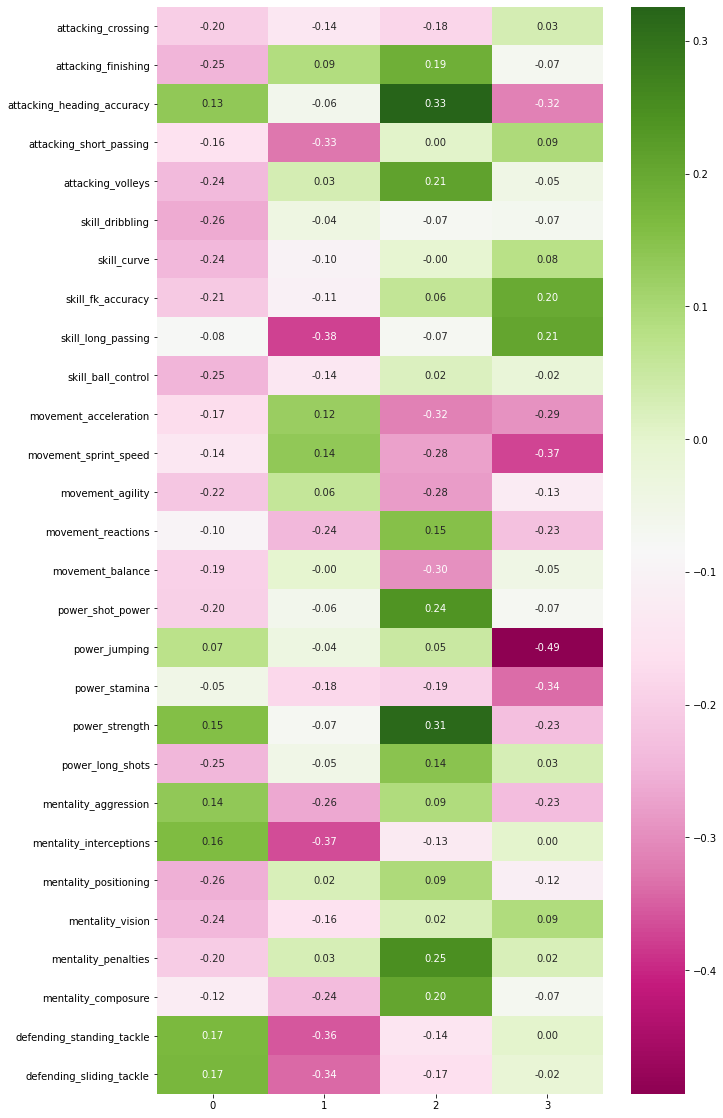

In [149]:
pcsT = pcs.transpose()
import seaborn as sns
plt.figure(figsize = (10,20))
ax = sns.heatmap(pcsT,yticklabels=X.columns.values,annot=True, fmt=".2f",cmap="PiYG")

El siguiente gráfico muestra la composición de los pesos de las dos primeras componentes principales. 

In [142]:
#Graph 1
data=[]

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=X.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Se crea el jugador perfecto para ver a donde se ubica en nuestra visualización, se lo agrega a los datos normalizados y a las componentes ya calculadas (sin usarlo).

In [150]:
MachineGunDict={'short_name':'MachineGun','overall':99}
for skills in skills_ratings:
    MachineGunDict[skills]=99
    
#Lo agregamos a la base:
df_acp=df_acp.append(MachineGunDict,ignore_index=True)
X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a estandarizar con el dato agregado 
#pero con la estandarización de la base sin el dato nuevo
X_projected=pca.transform(X_scaled) # volvemos a proyectar pero con el dato nuevo

**Graficamos a los jugadores usando las dos primeras componentes de PCA, proyectamos los datos (de dim 28) en ese espacio de dimensión 2**

Identificamos a MachineGun y a un jugador en particular, por ejemplo, Lio Messi: 

In [152]:
#Graph 2
#Choose your player
recherche_joueur=df_acp["short_name"]=='L. Messi'

bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86
bool_machinegun=df_acp["short_name"]=='MachineGun'

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Crack',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[2],size=7),mode='markers+text')

acp_no_crack =go.Scatter(x=X_projected[bool_no_crack,0], y=X_projected[bool_no_crack,1],name='Average player',
                         text=df_acp.loc[bool_no_crack,'short_name'],
                         opacity=0.6,marker=dict(color=palette[1],size=3),mode='markers')

acp_machinegun =go.Scatter(x=X_projected[bool_machinegun,0], y=X_projected[bool_machinegun,1],name='Perfect player',
                           textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=0.6,marker=dict(color=palette[3],size=30),mode='markers+text')


joueur_recherche =go.Scatter(x=X_projected[recherche_joueur,0], y=X_projected[recherche_joueur,1],name='Searched player',
                           text=df_acp.loc[recherche_joueur,'short_name'],
                            textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=1,marker=dict(color=palette[4],size=40),mode='markers+text')

data=[acp_no_crack,acp_crack,acp_machinegun,joueur_recherche]

layout = go.Layout(title="ACP - Fifa Players",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Se puede comparar dos equipos y ver los perfiles de los jugadores en las dos primeras componentes.

In [154]:
teamA='Liverpool'
teamB='Manchester United'

bool_teamA=df_acp["club_name"]==teamA
bool_teamB=df_acp["club_name"]==teamB

palette=['navy','red','#A2D5F2','orange','green','pink','grey']  
data=[]

acp_teamA =go.Scatter(x=X_projected[bool_teamA,0], y=X_projected[bool_teamA,1],name=teamA,
                      text=df_acp.loc[bool_teamA,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[1],size=10),mode='markers+text')

acp_teamB =go.Scatter(x=X_projected[bool_teamB,0], y=X_projected[bool_teamB,1],name=teamB,
                      text=df_acp.loc[bool_teamB,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[4],size=10),mode='markers+text')

acp_all =go.Scatter(x=X_projected[:,0], y=X_projected[:,1],name='All',
                         text=df_acp.loc[:,'short_name'],
                         opacity=0.3,marker=dict(color=palette[6],size=3),mode='markers')


data=[acp_teamA,acp_teamB,acp_all]

layout = go.Layout(title="ACP - {} vs {}".format(teamA,teamB),titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 5 .-Clustering

**Trabajo en grupo**: Veamos ahora que agrupamientos podemos hacer de los jugadores usando las dos/tres o cuatro primeras componentes. 

Presentar este ejercicio (con comentarios) pero con los datos FIFA2021 para el práctico entregable

In [213]:
##Hay que quitar MachineGun para Clustering
df_acp=df.loc[:]
df_acp=df_acp[(df_acp["player_positions"]!='GK')&(df['overall']>70)].reset_index(drop=True)

X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a normalizar (ya estaba ajustada)
X_projected=pca.transform(X_scaled) #volvemos a proyectar 
print('dimensiones de la base proyectada:', X_projected.shape)

dimensiones de la base proyectada: (4068, 4)


In [214]:
print(len(df_acp))
df_acp.head()

4068


sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     188545  https://sofifa.com/player/188545/robert-lewand...   
3     190871  https://sofifa.com/player/190871/neymar-da-sil...   
4     192985  https://sofifa.com/player/192985/kevin-de-bruy...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   33  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35  1985-02-05   
2     R. Lewandowski                   Robert Lewandowski   31  1988-08-21   
3          Neymar Jr        Neymar da Silva Santos Júnior   28  1992-02-05   
4       K. De Bruyne                      Kevin De Bruyne   29  1991-06-28   

   height_cm  weight_kg nationality            club_name  \
0        170         72   Argentina         FC Barcelona   
1        187         83    Portugal             Juventus   
2        184         80      Poland    FC Bayern München   
3        175         68      Brazil  Paris Saint-Germain   
4        181         70     Belgium      Manchester City   

              league_name  league_rank  overall  potential  value_eur  \
0  Spain Primera Division          1.0       93         93   67500000   
1         Italian Serie A          1.0       92         92   46000000   
2    German 1. Bundesliga          1.0       91         91   80000000   
3          French Ligue 1          1.0       91         91   90000000   
4  English Premier League          1.0       91         91   87000000   

   wage_eur player_positions preferred_foot  international_reputation  \
0    560000       RW, ST, CF           Left                         5   
1    220000           ST, LW          Right                         5   
2    240000               ST          Right                         4   
3    270000          LW, CAM          Right                         5   
4    370000          CAM, CM          Right                         4   

   weak_foot  skill_moves    work_rate             body_type real_face  \
0          4            4   Medium/Low                 Messi       Yes   
1          4            5     High/Low            C. Ronaldo       Yes   
2          4            4  High/Medium  PLAYER_BODY_TYPE_276       Yes   
3          5            5  High/Medium                Neymar       Yes   
4          5            4    High/High  PLAYER_BODY_TYPE_321       Yes   

   release_clause_eur                                        player_tags  \
0         138400000.0  #Dribbler, #Distance Shooter, #FK Specialist, ...   
1          75900000.0  #Aerial Threat, #Dribbler, #Distance Shooter, ...   
2         132000000.0              #Distance Shooter, #Clinical Finisher   
3         166500000.0  #Speedster, #Dribbler, #Playmaker, #FK Special...   
4         161000000.0  #Dribbler, #Playmaker, #Engine, #Distance Shoo...   

  team_position  team_jersey_number loaned_from      joined  \
0           CAM                10.0         NaN  2004-07-01   
1            LS                 7.0         NaN  2018-07-10   
2            ST                 9.0         NaN  2014-07-01   
3            LW                10.0         NaN  2017-08-03   
4           RCM                17.0         NaN  2015-08-30   

   contract_valid_until nation_position  nation_jersey_number  pace  shooting  \
0                2021.0              RW                  10.0  85.0      92.0   
1                2022.0              LS                   7.0  89.0      93.0   
2                2023.0             NaN                   NaN  78.0      91.0   
3                2022.0             NaN                   NaN  91.0      85.0   
4                2023.0             RCM                   7.0  76.0      86.0   

   passing  dribbling  defending  physic  gk_diving  gk_handling  gk_kicking  \
0     91.0       95.0       38.0    65.0    

k-medias y visualizar los clusters encontrados en las dos primeras componentes

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

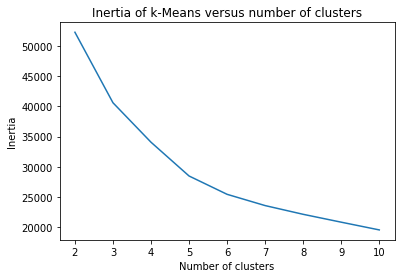

In [215]:
# Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 10 clusters
scores = [KMeans(n_clusters=i).fit(X_projected).inertia_ for i in range(2,11)]

plt.plot(np.arange(2, 11), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [216]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(X_projected) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  34079.5741606608


In [217]:
# columna con los valores 0, 1, 2, 3, 4 que indica a que cluster pertenece cada jugador según kMeans
df_projected = pd.DataFrame(X_projected, columns = ['pca1', 'pca2', 'pca3', 'pca4'])
df_projected["cluster"] = clusters
df_projected.sample(5)

pca1      pca2      pca3      pca4  cluster
2571 -1.093672 -0.954111 -0.721911  1.666557        2
649  -2.387541  3.234129  2.750007 -2.423112        0
3115 -0.024639 -1.923269  1.054220  0.134144        2
1737 -3.027383  1.429971 -0.055336 -0.961162        0
1257  1.186850 -1.800183  1.020750 -0.372712        3

In [218]:
data=[]
bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86

kmean_clusters = go.Scatter(x=X_projected[:,0], y=X_projected[:,1],
                           mode='markers',
                        text=df_acp.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = df_projected["cluster"].astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Top players',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,acp_crack]

layout = go.Layout(title="ACP + Clustering kMeans ",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

En el gráfico podemos observar el resultado de aplicar kMeans a las cuatro primeras componentes principales y proyectarlo sobre las dos primeras. Por eso se puede observar un poco de mezcla en las fronteras de cada cluster. La gran mayoria de los jugadores "crack" están en el cluster rojo, con lo cual este cluster representa quizás a los mejores jugadores en general, pero habría que seguir analizando las variables más influyentes para determinar que representarían los otros clusters.

Mean Shift y visualizar en las dos primeras componentes 

In [219]:
ms = MeanShift(bandwidth=2.5, bin_seeding=True)

ms.fit(X_projected)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 4


In [220]:
# columna con los valores 0, 1, 2, 3 que indica a que cluster pertenece cada jugador según kMeans
df_projected["cluster2"] = clusters2
df_projected.sample(5)

pca1      pca2      pca3      pca4  cluster  cluster2
1170 -4.144721  1.698590 -0.448509  1.110584        0         1
734   2.358038 -2.554812  1.595628 -0.983959        3         0
3732 -1.158714  3.431241  1.453318 -0.820300        0         1
2436 -3.718703  2.247221 -1.264305  3.181689        0         1
901  -1.831667 -0.263900 -3.062964 -0.921589        3         0

In [221]:
data=[]
bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86

kmean_clusters = go.Scatter(x=X_projected[:,0], y=X_projected[:,1],
                           mode='markers',
                        text=df_acp.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = df_projected["cluster2"].astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Top players',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,acp_crack]

layout = go.Layout(title="ACP + Clustering Mean Shift ",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

En este caso el algoritmo de Mean-shift calculado para las primeras 4 componentes principales y proyectado en las primeras 2 encuentra basicamente dos clusters. Veamos ahora si proyectamos los jugadores en las primeras dos componentes y coloreamos por tipo de posición, si el gráfico tienen alguna relación con los dos clusters de Mean-shift, porque recordemos que los delanteros se separaban bastante bien de los defensores cuando habíamos usado tsne.

In [224]:
dict_pos = {'CB': 0, 'RB': 0, 'LB': 0, 'RWB': 0, 'LWB': 0,
        'CM': 1, 'CDM': 1, 'CAM': 1, 'RM': 1, 'LM': 1, 
        'ST': 2, 'CF': 2, 'RF': 2, 'LF': 2, 'RW': 2, 'LW': 2,
        'GK': 3}
df_projected['type_position_num'] =  df_acp["first_position"].replace(dict_pos)
df_projected.head()

pca1      pca2      pca3      pca4  cluster  cluster2  \
0 -9.606046 -3.185605  1.723961 -0.803959        2         1   
1 -7.566386 -2.190723  3.491363 -4.311189        2         1   
2 -6.141017 -2.373977  4.089790 -3.110436        2         1   
3 -9.173138 -2.025898  0.577737 -0.865903        2         1   
4 -7.275534 -5.684186  1.502979 -0.572429        2         1   

   type_position_num  
0                  2  
1                  2  
2                  2  
3                  2  
4                  1

In [241]:
data=[]
bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86

bool_defensor=df_projected['type_position_num']==0
bool_medio=df_projected['type_position_num']==1
bool_delantero=df_projected['type_position_num']==2

palette=['yellow','navy','red','#A2D5F2','orange','green','pink','grey']  


acp_def=go.Scatter(x=X_projected[bool_defensor,0], y=X_projected[bool_defensor,1],name='Defensores',
                      text=df_acp.loc[bool_defensor,'short_name'],
                      opacity=0.9,marker=dict(color=palette[1],size=5),mode='markers')

acp_med=go.Scatter(x=X_projected[bool_medio,0], y=X_projected[bool_medio,1],name='Mediocampistas',
                      text=df_acp.loc[bool_medio,'short_name'],
                      opacity=0.9,marker=dict(color=palette[0],size=5),mode='markers')

acp_del=go.Scatter(x=X_projected[bool_delantero,0], y=X_projected[bool_delantero,1],name='Delanteros',
                      text=df_acp.loc[bool_delantero,'short_name'],
                      opacity=0.9,marker=dict(color=palette[2],size=5),mode='markers')

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Top players',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[acp_def,acp_med,acp_del,acp_crack]

layout = go.Layout(title="ACP + Posición",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Como se puede observar, los defensores y delanteros estan bastante separados y los mediocampistas se mezclan con ambos porque suelen ser jugadores más versátiles. Entonces quizas los dos clusters que encontró Mean-shift representan delanteros o mediocampistas con habilidades más parecidas a las de los delanteros y defensores o mediocampistas que tienen también habilidades de defensores.